# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 11: Evolution of Density Matrix in Liouville Space
In this tutorial you will see how to evolve the desnity matrix in time by solving Liouville-Von Neumann equation in Liouville Space of single spin half system using ODE solver.

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_beta/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 9.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [100] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-400.22811765]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


## Zeeman Halitonian in Rotating Frame

In [8]:
OmegaRF = [-System.gammaH1*B0]
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## Converting to Liouvillian

In [9]:
Hz_L = System.CommutationSuperoperator(Hz)
Hzr_L = System.CommutationSuperoperator(Hzr)
rho_in_L = System.Vector_L(rho_in)
rhoeq_L = System.Vector_L(rhoeq)

In [10]:
"""
Matrix Repersentation of Hzr
""";
Matrix(Hzr)

Matrix([
[-314.15926527977,               0],
[               0, 314.15926527977]])

In [11]:
"""
Matrix Repersentation of Hzr_L
""";
Matrix(Hzr_L)

Matrix([
[0,                0,               0, 0],
[0, -628.31853055954,               0, 0],
[0,                0, 628.31853055954, 0],
[0,                0,               0, 0]])

In [12]:
"""
Matrix Repersentation of rho_in
""";
Matrix(rho_in)

Matrix([
[0.5,    0],
[  0, -0.5]])

In [13]:
"""
Matrix Repersentation of rho_in_L
""";
Matrix(rho_in_L)

Matrix([
[ 0.5],
[   0],
[   0],
[-0.5]])

## Pulse

In [14]:
"""
Rotate the magnetization about Y-axis, by an angle theta.
""";
pulse_angle = 130.0
rho_L = System.Rotate_L(rho_in_L,pulse_angle,np.sum(Sy,axis=0)) 

## Relaxation Constant

In [15]:
'''
Define Relaxation superoperator
state vector in Liouville space, | rho ) 
| rho )  = a | |1/2><1/2| ) + b | |1/2><-1/2| ) + c | |-1/2><1/2| ) + d | |-1/2><-1/2| )
                population          coherence           coherence           population 
''';
R1 = 1
R2 = 5
R = [R1,R2,R2,R1]
Rprocess = "Phenomenological"
R_L = System.Relaxation_L(Rprocess,R,Sx,Sy,Sz,Sp,Sm)

In [16]:
"""
Matrix Repersentation of R
""";
Matrix(R_L)

Matrix([
[1.0,   0,   0,   0],
[  0, 5.0,   0,   0],
[  0,   0, 5.0,   0],
[  0,   0,   0, 1.0]])

## Evolution of Density Matrix

In [17]:
dt = 0.0005
AQ = 3.0
Npoints = int(AQ/dt)
print("Number of points in the simulation", Npoints)

"""
option for solver, "method": "Unitary Propagator", "Relaxation" or "ODE Solver"
"""
method = "ODE Solver"

start_time = time.time()
t, rho_t = System.Evolution_L(rhoeq_L,rho_L,Sx,Sy,Hzr_L - 1j * R_L,dt,Npoints,method)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 6000
Total time = 1.5585319995880127 seconds 


## Expectation value

In [18]:
EXP_T = np.sum(Sx,axis=0) + 1j * np.sum(Sy,axis=0)
EXP_Z = np.sum(Sz,axis=0)

LEXP_T = System.Detection_L(EXP_T)
LEXP_Z = System.Detection_L(EXP_Z)

t, Mp = System.Expectation_L(rho_t,LEXP_T,dt,Npoints)
t, Mz = System.Expectation_L(rho_t,LEXP_Z,dt,Npoints)

## Fourier Transform

In [19]:
fs = 1.0/dt
freq, spectrum = System.FourierTransform(Mp,fs,1)

## Plotting

<IPython.core.display.Javascript object>


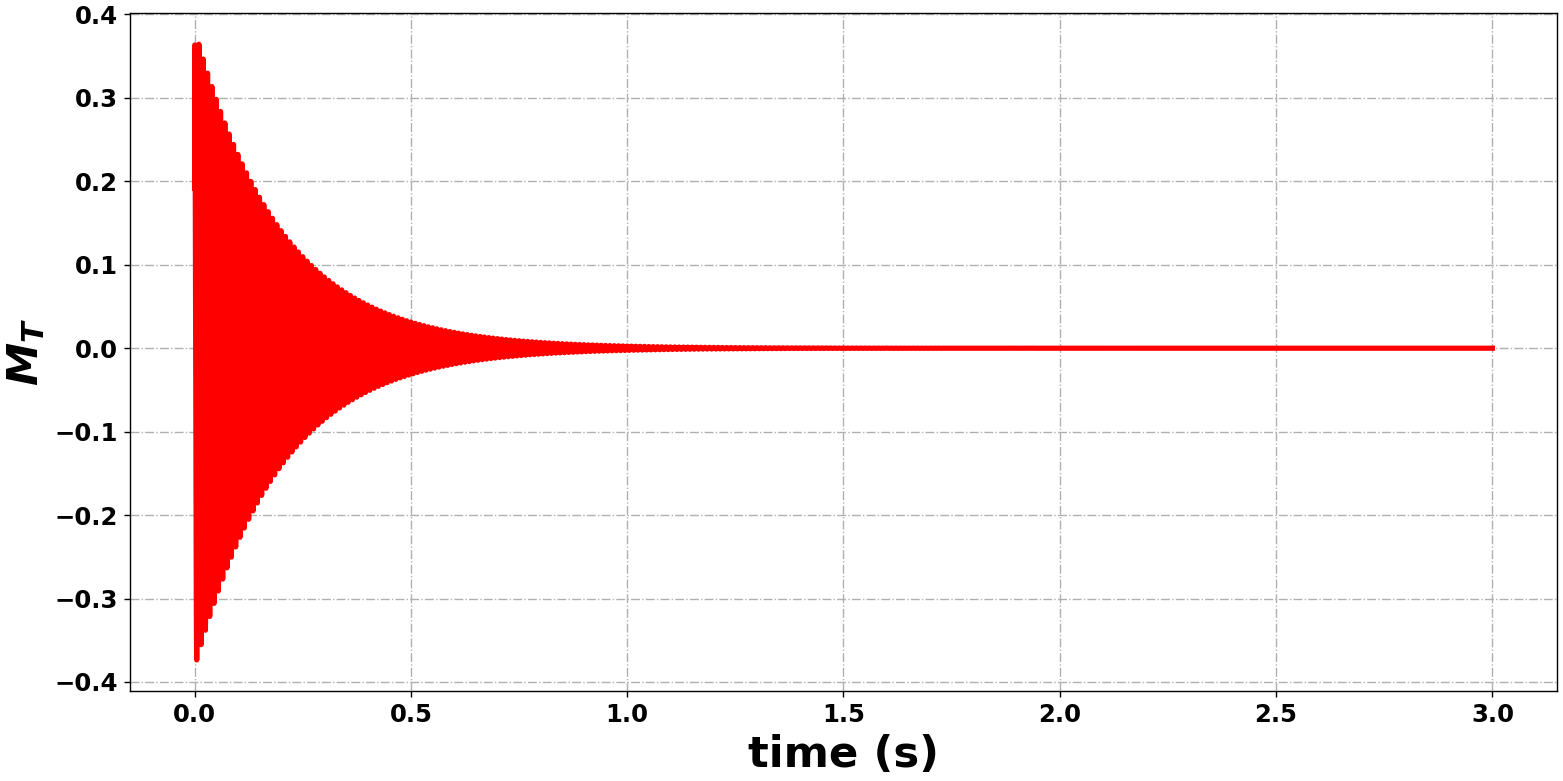

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [20]:
System.Plotting(3,t,Mp,"time (s)",r"$M_{T}$","red")

<IPython.core.display.Javascript object>


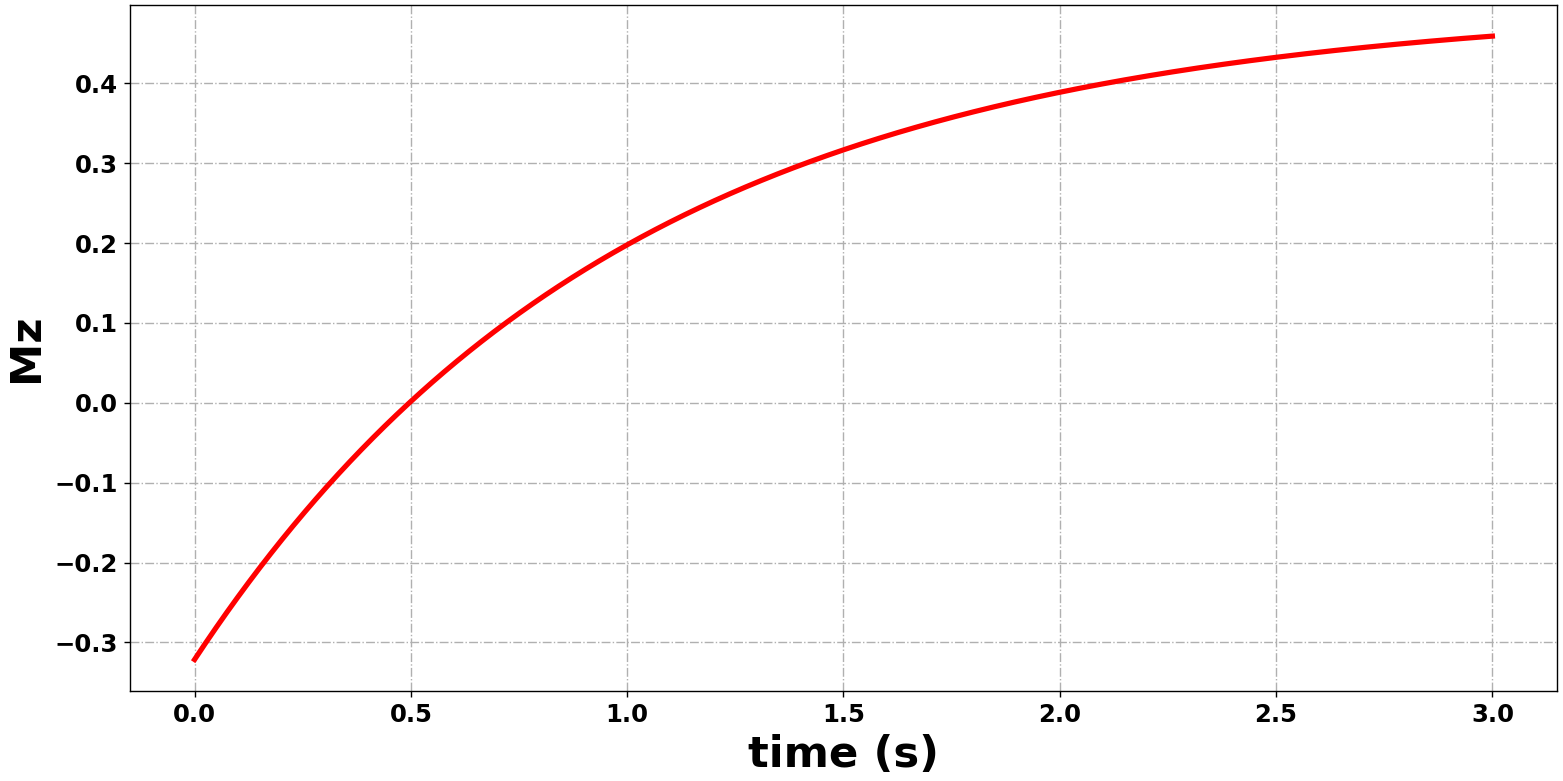

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [21]:
System.Plotting(4,t,Mz,"time (s)","Mz","red")

<IPython.core.display.Javascript object>


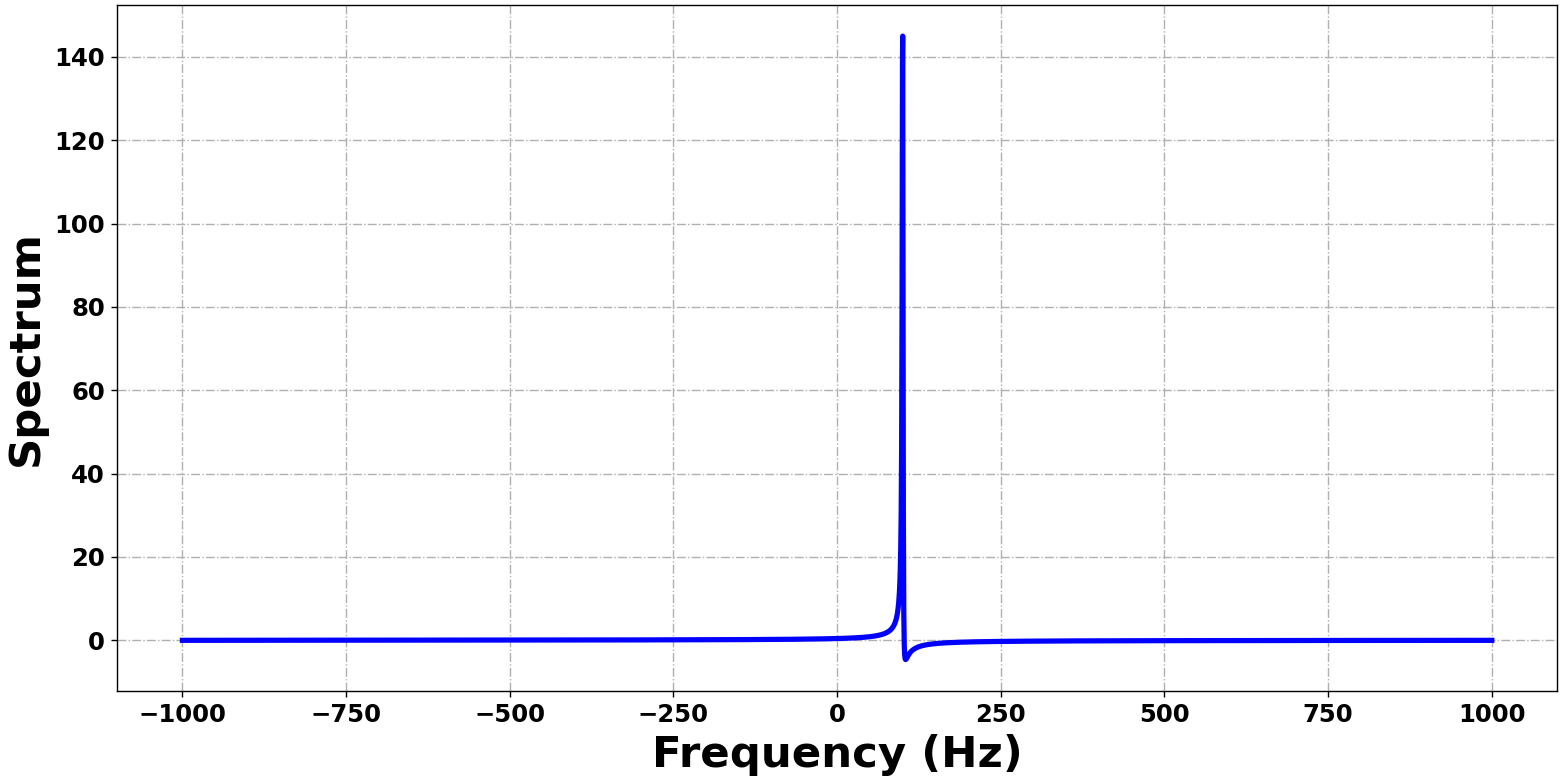

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [22]:
PH0 = -10.0
spectrum_PH0 = System.PhaseAdjust_PH0(spectrum,PH0)
System.Plotting(5,freq,spectrum_PH0,"Frequency (Hz)","Spectrum","blue")

## Plotting on a sphere

<IPython.core.display.Javascript object>


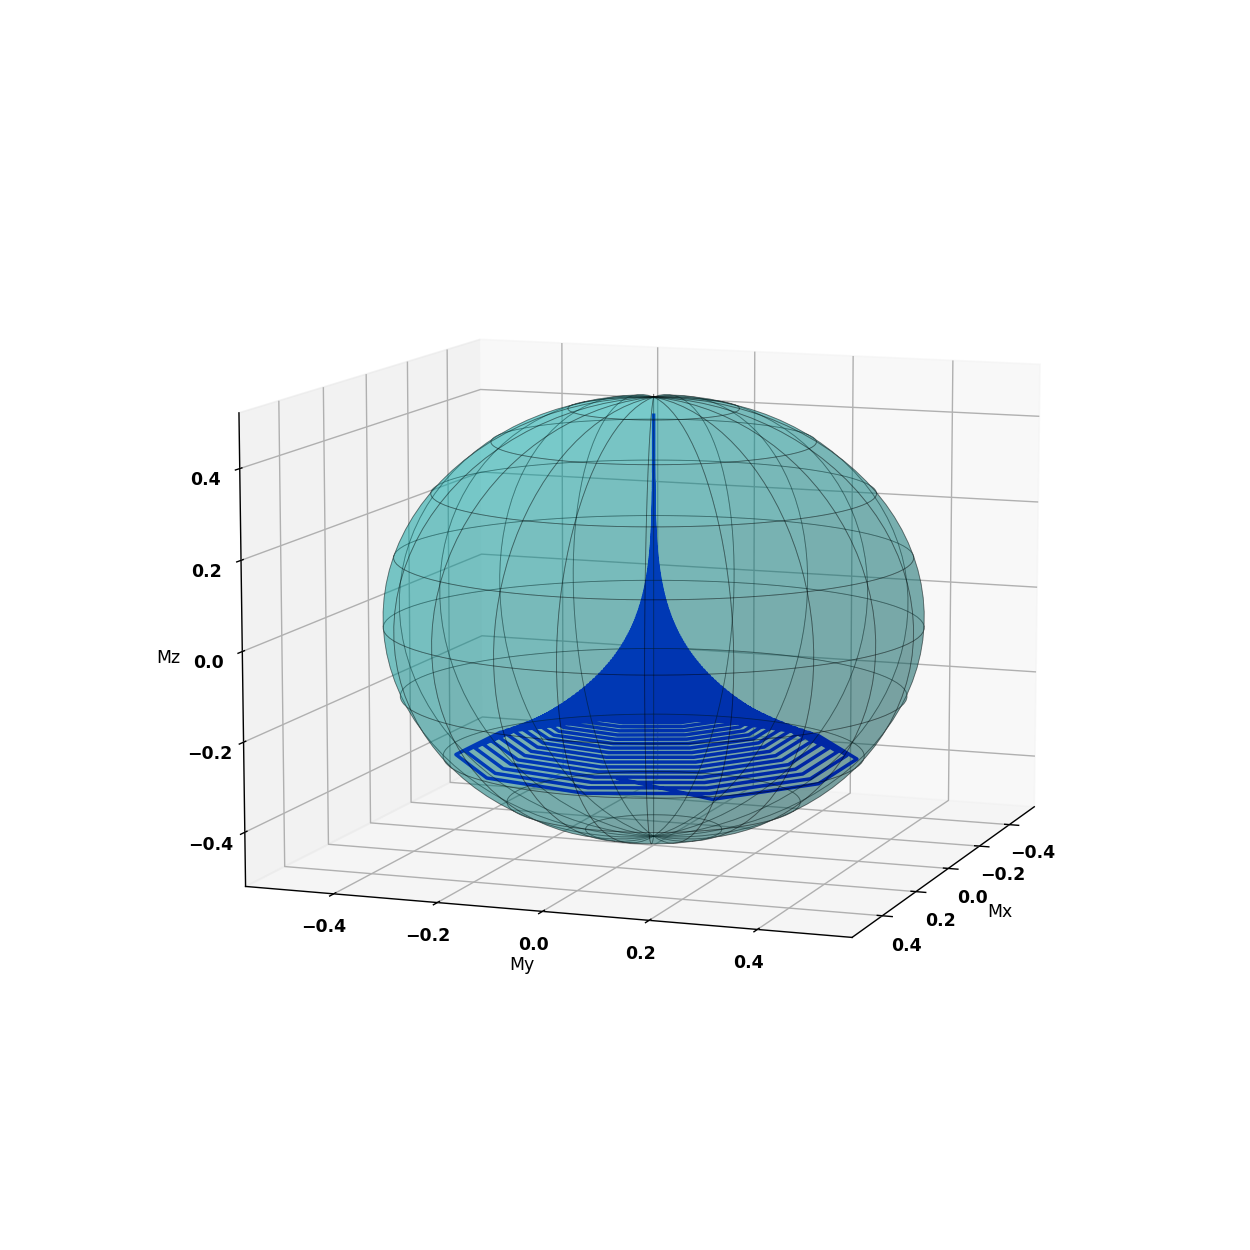

/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1813: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1814: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [23]:
plot_vector = False
scale_datapoints = 2
System.PlottingSphere(8,Mp.real,Mp.imag,Mz,rhoeq,np.sum(Sz,axis=0),plot_vector,scale_datapoints)

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com